cluster:apiserver_current_inflight_requests:sum:max_over_time:2m
{"alerts":count by (alertname) (alerts{alertname=~"etcd.+"}),
"network_latency":instance:etcd_network_peer_round_trip_time_seconds:histogram_quantile,
"disk":{__name__="instance:etcd_disk_wal_fsync_duration_seconds:histogram_quantile",quantile="0.99"}}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from prometheus_api_client import PrometheusConnect

In [26]:
managed_cluster_df = pd.read_csv('./datasets/managed_clusters.csv')
hub_cluster_df = pd.read_csv('./datasets/hub_cluster.csv')

In [2]:
disk_ts =  pd.read_csv('/Users/sponnur/PycharmProjects/pythonProject1/disk_2022_05_22_1_15m.csv')

In [105]:
api_ts =  pd.read_csv('/Users/sponnur/PycharmProjects/pythonProject1/api_server_count_2022_05_22_1_15m.csv')

In [150]:
alerts_ts =  pd.read_csv('/Users/sponnur/PycharmProjects/pythonProject1/alerts_2022_05_22_1_15m.csv')

In [3]:
disk_ts.head()

,timestamp,disk,cluster_id
0,2022-05-22 17:45:00,0.003583,6f797563-a5b6-4af9-bda1-268af05cd179
1,2022-05-22 18:00:00,0.003463,6f797563-a5b6-4af9-bda1-268af05cd179
2,2022-05-22 18:15:00,0.003465,6f797563-a5b6-4af9-bda1-268af05cd179
3,2022-05-22 18:30:00,0.003527,6f797563-a5b6-4af9-bda1-268af05cd179
4,2022-05-22 18:45:00,0.003732,6f797563-a5b6-4af9-bda1-268af05cd179


In [4]:
network_ts =  pd.read_csv('/Users/sponnur/PycharmProjects/pythonProject1/network_latency_2022_05_22_1_15m.csv') 

In [30]:
managed_cluster_df.set_index('_id',inplace=True)

In [31]:
network_ts_managed = network_ts.join(managed_cluster_df,on='cluster_id',how='inner')

In [106]:
api_ts_managed = api_ts.join(managed_cluster_df,on='cluster_id',how='inner')

In [90]:
disk_ts_managed = disk_ts.join(managed_cluster_df,on='cluster_id',how='inner')

In [91]:
disk_ts_managed.head()

,timestamp,disk,cluster_id,is_managed
3744,2022-05-22 17:45:00,0.003418,0007753d-3cdc-4c4f-bdb5-c57b3715b55f,1
3745,2022-05-22 18:00:00,0.003514,0007753d-3cdc-4c4f-bdb5-c57b3715b55f,1
3746,2022-05-22 18:15:00,0.003770,0007753d-3cdc-4c4f-bdb5-c57b3715b55f,1
3747,2022-05-22 18:30:00,0.003288,0007753d-3cdc-4c4f-bdb5-c57b3715b55f,1
3748,2022-05-22 18:45:00,0.003910,0007753d-3cdc-4c4f-bdb5-c57b3715b55f,1


In [5]:
network_ts.head()

,timestamp,network_latency,cluster_id
0,2022-05-22 17:45:00,0.025344,6f797563-a5b6-4af9-bda1-268af05cd179
1,2022-05-22 18:00:00,0.025344,6f797563-a5b6-4af9-bda1-268af05cd179
2,2022-05-22 18:15:00,0.025344,6f797563-a5b6-4af9-bda1-268af05cd179
3,2022-05-22 18:30:00,0.025344,6f797563-a5b6-4af9-bda1-268af05cd179
4,2022-05-22 18:45:00,0.025344,6f797563-a5b6-4af9-bda1-268af05cd179


In [81]:
indexes = pd.date_range('2022-05-23 00:00:00','2022-05-23 23:45:00',freq='15T')
indexes_df = pd.DataFrame(indexes,columns=['timestamp'])

In [32]:
network_ts_managed.timestamp = pd.to_datetime(network_ts_managed.timestamp, infer_datetime_format=True)  

In [94]:
disk_ts_managed.timestamp = pd.to_datetime(disk_ts_managed.timestamp, infer_datetime_format=True)  

In [107]:
api_ts_managed.timestamp = pd.to_datetime(api_ts_managed.timestamp, infer_datetime_format=True)  

In [83]:
indexes_df.shape

(96, 1)

In [23]:
empty_clusters = []

In [136]:
network_ts_managed[['timestamp','network_latency']].shape

(173522, 2)

In [79]:
network_ts_managed['timestamp'].dt.date.min(),network_ts_managed['timestamp'].dt.date.max()

(datetime.date(2022, 5, 22), datetime.date(2022, 5, 23))

In [55]:
len(network_ts_managed['cluster_id'].unique())

613

In [58]:
sample = network_ts_managed[network_ts_managed['cluster_id'] == '0007753d-3cdc-4c4f-bdb5-c57b3715b55f']

In [87]:
network_ts_managed_clean = pd.DataFrame(columns=['timestamp','network_latency','cluster_id'])

In [92]:
disk_ts_managed_clean = pd.DataFrame(columns=['timestamp','disk','cluster_id'])

In [108]:
api_ts_managed_clean = pd.DataFrame(columns=['timestamp','api_server_count','cluster_id'])

In [56]:
from impyute.imputation.ts import locf

In [88]:
#change the dataframe to handle the missing data of that 
for cluster_id, cluster_df in network_ts_managed.groupby('cluster_id'):
    local_copy = cluster_df.copy(deep=True)
    local_copy = local_copy.drop_duplicates(['timestamp'],keep='first')
    #print(local_copy.head())
    local_copy.set_index('timestamp',inplace=True)
    joined_df = indexes_df.join(local_copy,on='timestamp',how='left')[['timestamp','network_latency']]
    #print(joined_df.head())
    new_np = joined_df['network_latency'].to_numpy().reshape(1,96)
    try:
        c_result = locf(new_np,axis=0).reshape(96,1)
        joined_df['network_latency'] = c_result
        joined_df['cluster_id'] = cluster_id
        network_ts_managed_clean = pd.concat([network_ts_managed_clean,joined_df],ignore_index=True)
    except Exception as e:
        print(f'This cluster has no valid entries: {cluster_id}',e)
        empty_clusters.append(cluster_id)

This cluster has no valid entries: 462b2e0b-824c-46b1-b48c-3f664a5ab0b7 Error: Entire Column is NaN
This cluster has no valid entries: 86a6d168-2b19-4cfc-8a9e-c8e7bce8578d Error: Entire Column is NaN
This cluster has no valid entries: a7793e4a-0a09-4648-9631-533ce36cfd16 Error: Entire Column is NaN
This cluster has no valid entries: b752b30c-c521-41af-a1e8-9323346862ed Error: Entire Column is NaN
This cluster has no valid entries: bb2417e2-f4ea-4951-bbe0-75a33b692fc4 Error: Entire Column is NaN
This cluster has no valid entries: e76b9e5e-9480-4a2f-8484-52c463599417 Error: Entire Column is NaN
This cluster has no valid entries: eed2fdd7-ef2f-48bf-9695-f022dcd2651a Error: Entire Column is NaN


In [95]:
#change the dataframe to handle the missing data of that 
for cluster_id, cluster_df in disk_ts_managed.groupby('cluster_id'):
    local_copy = cluster_df.copy(deep=True)
    local_copy = local_copy.drop_duplicates(['timestamp'],keep='first')
    #print(local_copy.head())
    local_copy.set_index('timestamp',inplace=True)
    joined_df = indexes_df.join(local_copy,on='timestamp',how='left')[['timestamp','disk']]
    #print(joined_df.head())
    new_np = joined_df['disk'].to_numpy().reshape(1,96)
    try:
        c_result = locf(new_np,axis=0).reshape(96,1)
        joined_df['disk'] = c_result
        joined_df['cluster_id'] = cluster_id
        disk_ts_managed_clean = pd.concat([disk_ts_managed_clean,joined_df],ignore_index=True)
    except Exception as e:
        print(f'This cluster has no valid entries: {cluster_id}',e)
        empty_clusters.append(cluster_id)

This cluster has no valid entries: a7793e4a-0a09-4648-9631-533ce36cfd16 Error: Entire Column is NaN


In [110]:
#change the dataframe to handle the missing data of that 
for cluster_id, cluster_df in api_ts_managed.groupby('cluster_id'):
    local_copy = cluster_df.copy(deep=True)
    local_copy = local_copy.drop_duplicates(['timestamp'],keep='first')
    #print(local_copy.head())
    local_copy.set_index('timestamp',inplace=True)
    joined_df = indexes_df.join(local_copy,on='timestamp',how='left')[['timestamp','api_server_count']]
    #print(joined_df.head())
    new_np = joined_df['api_server_count'].to_numpy().reshape(1,96)
    try:
        c_result = locf(new_np,axis=0).reshape(96,1)
        joined_df['api_server_count'] = c_result
        joined_df['cluster_id'] = cluster_id
        api_ts_managed_clean = pd.concat([api_ts_managed_clean,joined_df],ignore_index=True)
    except Exception as e:
        print(f'This cluster has no valid entries: {cluster_id}',e)
        empty_clusters.append(cluster_id)

This cluster has no valid entries: a7793e4a-0a09-4648-9631-533ce36cfd16 Error: Entire Column is NaN


In [96]:
disk_ts_managed_clean.shape

(65568, 3)

In [89]:
network_ts_managed_clean.shape

(58176, 3)

In [115]:
single_cluster_disk = disk_ts_managed_clean[disk_ts_managed_clean['cluster_id'] == '0007753d-3cdc-4c4f-bdb5-c57b3715b55f']['disk']

In [117]:
single_cluster_network =  network_ts_managed_clean[network_ts_managed_clean['cluster_id'] == '0007753d-3cdc-4c4f-bdb5-c57b3715b55f']['network_latency']

In [119]:
single_cluster_api =  api_ts_managed_clean[api_ts_managed_clean['cluster_id'] == '0007753d-3cdc-4c4f-bdb5-c57b3715b55f']['api_server_count']

In [137]:
single_cluster_disk.shape, single_cluster_network.shape, single_cluster_api.shape

((96,), (96,), (96,))

In [141]:
new_df = pd.concat([single_cluster_disk,single_cluster_network,single_cluster_api],axis=1,ignore_index=True)

In [144]:
new_df.rename(columns={0: "disk", 1: "network_latency",2:"api"},inplace=True)

In [121]:
from statsmodels.tsa.stattools import grangercausalitytests

In [146]:
grangercausalitytests(new_df[['disk','api']],maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0798  , p=0.7781  , df_denom=92, df_num=1
ssr based chi2 test:   chi2=0.0824  , p=0.7740  , df=1
likelihood ratio test: chi2=0.0824  , p=0.7741  , df=1
parameter F test:         F=0.0798  , p=0.7781  , df_denom=92, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.7877 , p=0.0000  , df_denom=89, df_num=2
ssr based chi2 test:   chi2=24.8998 , p=0.0000  , df=2
likelihood ratio test: chi2=22.0887 , p=0.0000  , df=2
parameter F test:         F=11.7877 , p=0.0000  , df_denom=89, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=14.5047 , p=0.0000  , df_denom=86, df_num=3
ssr based chi2 test:   chi2=47.0560 , p=0.0000  , df=3
likelihood ratio test: chi2=38.0782 , p=0.0000  , df=3
parameter F test:         F=14.5047 , p=0.0000  , df_denom=86, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=10.7102 , p=0.0000  , df_d

{1: ({'ssr_ftest': (0.07984283548819299, 0.7781452515962546, 92.0, 1),
   'ssr_chi2test': (0.08244640621063407, 0.7740090898896825, 1),
   'lrtest': (0.08241065105448797, 0.7740567671010992, 1),
   'params_ftest': (0.07984283548819837, 0.7781452515962546, 92.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (11.787680833135113, 2.8749227638398002e-05, 89.0, 2),
   'ssr_chi2test': (24.899820186847204, 3.91807501089983e-06, 2),
   'lrtest': (22.08873185726543, 1.5976911188675267e-05, 2),
   'params_ftest': (11.787680833125936, 2.8749227638606585e-05, 89.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (14.504718208572708, 9.98493170520605e-08, 86.0, 3),
   'ssr_chi2test': (47.05600442083472, 3.381564547900707e-10, 3),
   'lrtest': (38.078187936918766, 2.7207671431314377e-08, 3),
   'params_ftest': (14.504718208580577, 9.984931705129485e-08, 86.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
 

In [149]:
grangercausalitytests(new_df[['network_latency','api']],maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5898  , p=0.2105  , df_denom=92, df_num=1
ssr based chi2 test:   chi2=1.6416  , p=0.2001  , df=1
likelihood ratio test: chi2=1.6276  , p=0.2020  , df=1
parameter F test:         F=1.5898  , p=0.2105  , df_denom=92, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3599  , p=0.2620  , df_denom=89, df_num=2
ssr based chi2 test:   chi2=2.8726  , p=0.2378  , df=2
likelihood ratio test: chi2=2.8295  , p=0.2430  , df=2
parameter F test:         F=1.3599  , p=0.2620  , df_denom=89, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7559  , p=0.0473  , df_denom=86, df_num=3
ssr based chi2 test:   chi2=8.9406  , p=0.0301  , df=3
likelihood ratio test: chi2=8.5365  , p=0.0361  , df=3
parameter F test:         F=2.7559  , p=0.0473  , df_denom=86, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.4204  , p=0.0548  , df_d

{1: ({'ssr_ftest': (1.5897515133782547, 0.21054980936921186, 92.0, 1),
   'ssr_chi2test': (1.6415912366405891, 0.2001072838848297, 1),
   'lrtest': (1.6275692658271055, 0.2020395831365407, 1),
   'params_ftest': (1.5897515133782867, 0.2105498093692067, 92.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.359885289923164, 0.2619712225033423, 89.0, 2),
   'ssr_chi2test': (2.8725666798376945, 0.2378099770623029, 2),
   'lrtest': (2.829549172776524, 0.24298037836080005, 2),
   'params_ftest': (1.3598852899232516, 0.261971222503322, 89.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.7558847237562527, 0.047282263946780125, 86.0, 3),
   'ssr_chi2test': (8.940602766604588, 0.03009111833870463, 3),
   'lrtest': (8.536546696716982, 0.036131637749668294, 3),
   'params_ftest': (2.7558847237554107, 0.04728226394682943, 86.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0.,

In [132]:
list(single_cluster_api)

[15.0,
 19.0,
 15.0,
 15.0,
 14.0,
 11.0,
 12.0,
 12.0,
 14.0,
 17.0,
 15.0,
 26.0,
 10.0,
 15.0,
 19.0,
 24.0,
 17.0,
 19.0,
 17.0,
 17.0,
 26.0,
 14.0,
 44.0,
 19.0,
 51.0,
 15.0,
 21.0,
 14.0,
 9.0,
 18.0,
 14.0,
 15.0,
 10.0,
 17.0,
 20.0,
 19.0,
 18.0,
 12.0,
 13.0,
 12.0,
 9.0,
 12.0,
 15.0,
 16.0,
 13.0,
 17.0,
 13.0,
 32.0,
 13.0,
 17.0,
 13.0,
 16.0,
 20.0,
 11.0,
 14.0,
 18.0,
 28.0,
 14.0,
 13.0,
 16.0,
 12.0,
 16.0,
 14.0,
 16.0,
 29.0,
 25.0,
 12.0,
 12.0,
 14.0,
 13.0,
 15.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0]

In [154]:
alerts_ts.head()

,timestamp,alerts,cluster_id
0,2022-05-22 17:45:00,55,NaN
1,2022-05-22 18:00:00,54,NaN
2,2022-05-22 18:15:00,53,NaN
3,2022-05-22 18:30:00,53,NaN
4,2022-05-22 18:45:00,51,NaN


In [156]:
from causalimpact import CausalImpact

In [166]:
new_df = pd.concat([new_df,indexes_df],axis=1,ignore_index=False)

In [175]:
pre = indexes_df[indexes_df['timestamp'] < '2022-05-23 16:00:00']

In [197]:
pre

,timestamp
0,2022-05-23 00:00:00
1,2022-05-23 00:15:00
2,2022-05-23 00:30:00
3,2022-05-23 00:45:00
4,2022-05-23 01:00:00
...,...
59,2022-05-23 14:45:00
60,2022-05-23 15:00:00
61,2022-05-23 15:15:00
62,2022-05-23 15:30:00


In [177]:
post = indexes_df[indexes_df['timestamp'] >= '2022-05-23 16:00:00']

In [186]:
new_df.set_index('timestamp',inplace=True)

In [187]:
new_df.columns

Index(['disk', 'network_latency', 'api'], dtype='object')

In [235]:
new_df_2 = new_df.drop(columns=['network_latency'])

In [247]:
new_df_4 = new_df.drop(columns=['disk'])

In [236]:
new_df_2.rename(columns={'disk':'y','api':'x'},inplace=True)

In [248]:
new_df_4.rename(columns={'network_latency':'y','api':'x'},inplace=True)

In [237]:
new_df_2.reset_index(inplace=True)

In [249]:
new_df_4.reset_index(inplace=True)

In [238]:
new_df_3 = new_df_2.drop(columns=['timestamp'])

In [250]:
new_df_5 = new_df_4.drop(columns=['timestamp'])

In [239]:
new_df_3['y'] = new_df_3['y'].astype('float')
new_df_3['x'] = new_df_3['x'].astype('float')

In [251]:
new_df_5['y'] = new_df_5['y'].astype('float')
new_df_5['x'] = new_df_5['x'].astype('float')

In [240]:
new_df_3.head()

,y,x
0,0.004865,15.0
1,0.003531,19.0
2,0.003884,15.0
3,0.003370,15.0
4,0.003485,14.0


In [252]:
new_df_5.head()

,y,x
0,0.023296,15.0
1,0.020992,19.0
2,0.012672,15.0
3,0.020992,15.0
4,0.012672,14.0


In [242]:
ci = CausalImpact(new_df_3, [0,74], [75,95])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(


In [253]:
ci2 = CausalImpact(new_df_5, [0,74], [75,95])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.0                0.08
Prediction (s.d.)         0.0 (0.0)          0.08 (0.01)
95% CI                    [0.0, 0.0]         [0.07, 0.1]

Absolute effect (s.d.)    -0.0 (0.0)         -0.0 (0.01)
95% CI                    [-0.0, 0.0]        [-0.02, 0.01]

Relative effect (s.d.)    -3.23% (8.73%)     -3.23% (8.73%)
95% CI                    [-18.85%, 15.36%]  [-18.85%, 15.36%]

Posterior tail-area probability p: 0.35
Posterior prob. of a causal effect: 64.54%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.0. In the absence of an
intervention, we would have expected an average response of 0.0.
The 95% interval of this counterfactual prediction is [0.0, 0.0].
Subtracting this prediction from the observed response yields
an estima

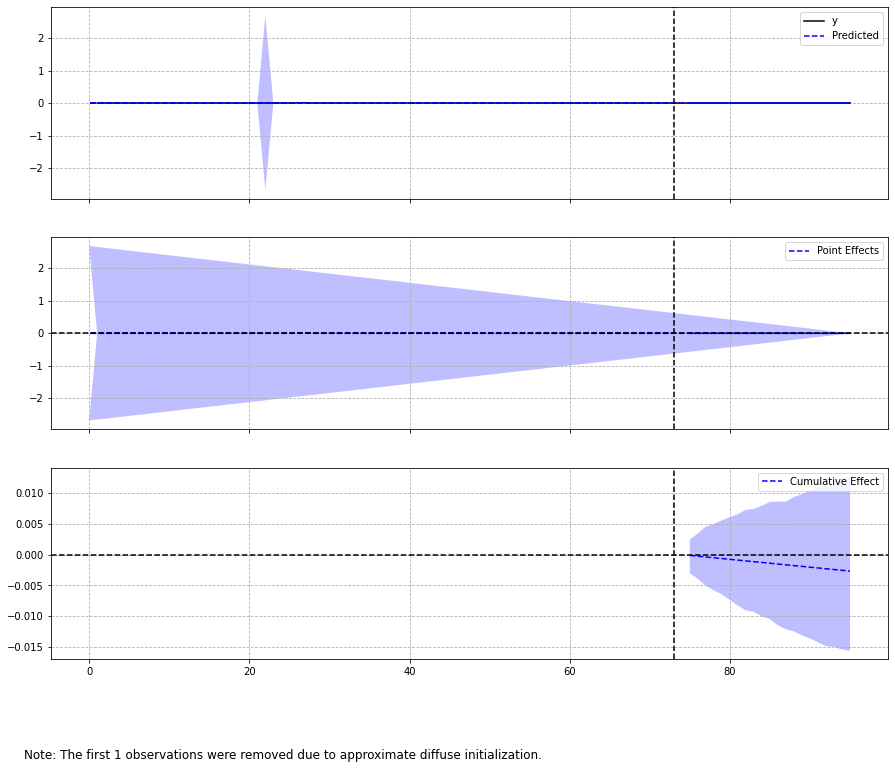

In [243]:
print(ci.summary())
print(ci.summary(output='report'))
ci.plot()

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.01               0.27
Prediction (s.d.)         0.01 (0.0)         0.31 (0.02)
95% CI                    [0.01, 0.02]       [0.27, 0.36]

Absolute effect (s.d.)    -0.0 (0.0)         -0.05 (0.02)
95% CI                    [-0.0, -0.0]       [-0.1, -0.0]

Relative effect (s.d.)    -14.97% (7.98%)    -14.97% (7.98%)
95% CI                    [-31.53%, -0.24%]  [-31.53%, -0.24%]

Posterior tail-area probability p: 0.02
Posterior prob. of a causal effect: 97.7%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.01. By contrast, in the absence of an
intervention, we would have expected an average response of 0.01.
The 95% interval of this counterfactual prediction is [0.01, 0.02].
Subtracting this prediction from the observed respons

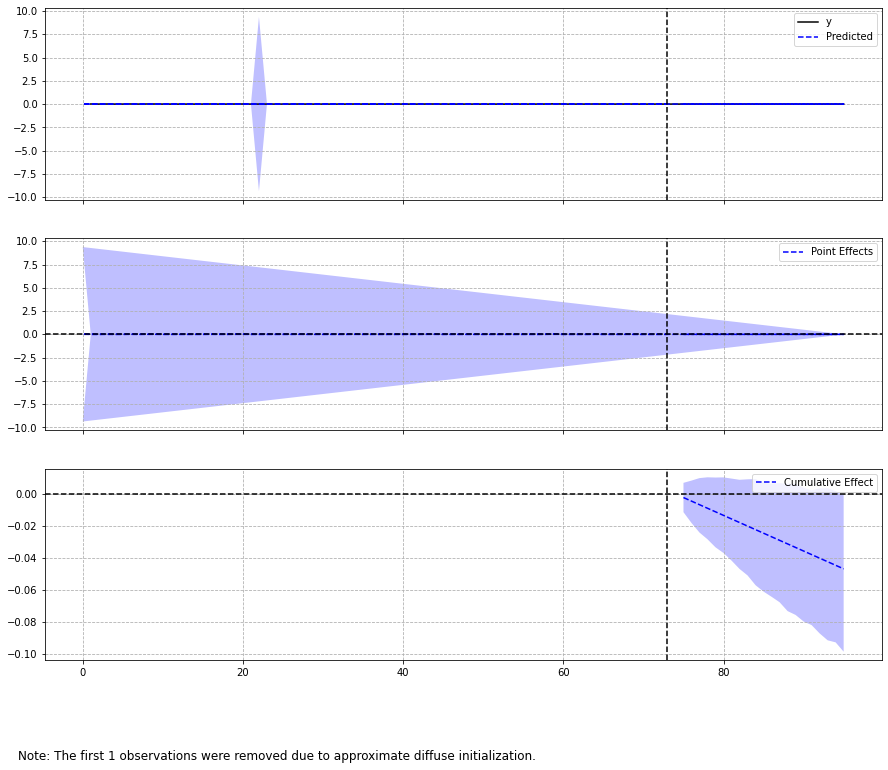

In [254]:
print(ci2.summary())
print(ci2.summary(output='report'))
ci2.plot()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    125.23             3756.86
Prediction (s.d.)         120.39 (0.27)      3611.81 (8.04)
95% CI                    [119.88, 120.93]   [3596.28, 3627.8]

Absolute effect (s.d.)    4.84 (0.27)        145.06 (8.04)
95% CI                    [4.3, 5.35]        [129.06, 160.58]

Relative effect (s.d.)    4.02% (0.22%)      4.02% (0.22%)
95% CI                    [3.57%, 4.45%]     [3.57%, 4.45%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 125.23. By contrast, in the absence of an
intervention, we would have expected an average response of 120.39.
The 95% interval of this counterfactual prediction is [119.88, 120.93].
Subtracting this prediction from t

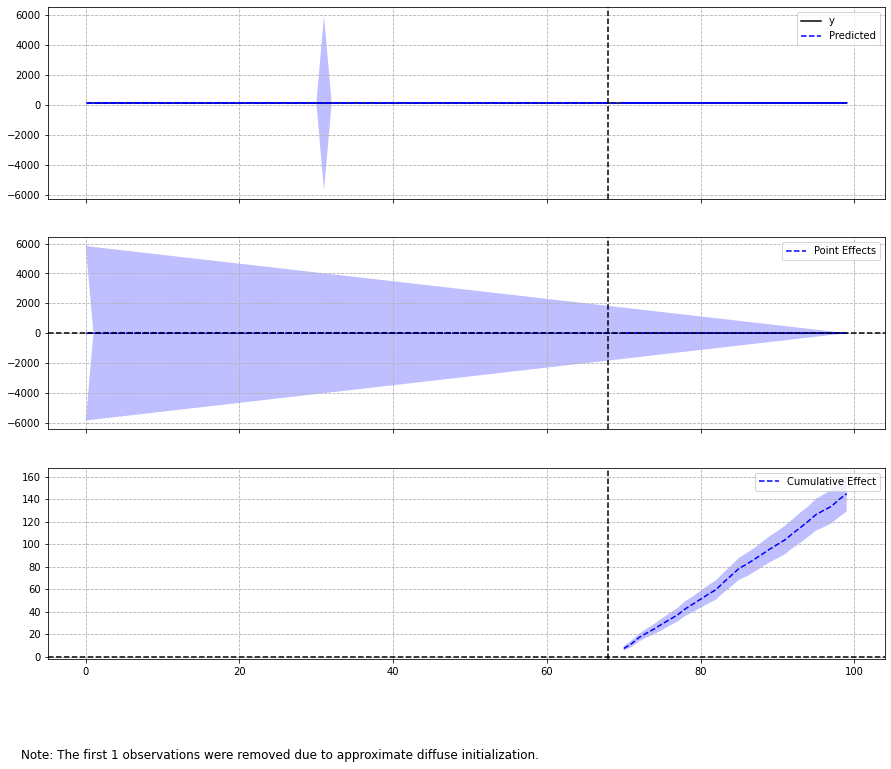

In [157]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact


np.random.seed(12345)
ar = np.r_[1, 0.9]
ma = np.array([1])
arma_process = ArmaProcess(ar, ma)
X = 100 + arma_process.generate_sample(nsample=100)
y = 1.2 * X + np.random.normal(size=100)
y[70:] += 5

data = pd.DataFrame({'y': y, 'X': X}, columns=['y', 'X'])
pre_period = [0, 69]
post_period = [70, 99]

ci = CausalImpact(data, pre_period, post_period)
print(ci.summary())
print(ci.summary(output='report'))
ci.plot()